In [110]:
import sys; sys.path.append('../3rdparty/ElasticRods/python')
import elastic_rods, elastic_knots
import numpy as np, matplotlib.pyplot as plt, time, io, os
from scipy.spatial.distance import cdist

from helpers import *
from parametric_curves import *
import py_newton_optimizer

from linkage_vis import LinkageViewer as Viewer, CenterlineViewer
from tri_mesh_viewer import PointCloudViewer, PointCloudMesh

%load_ext autoreload
%autoreload 2

import parallelism
parallelism.set_max_num_tbb_threads(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
#Returns the index of list b in a
def findSequence(a,b):
    for i in range(len(a)):
        if np.array_equal(a[i:i+len(b)],np.array(b)):
              return (i, i+len(b))
    

In [112]:
def findNearestVertex(A,B):
    distances = cdist(A, B)
    min_idx = np.unravel_index(np.argmin(distances), distances.shape)
    return min_idx[0], min_idx[1]

In [113]:
def interpolateEdge(a,b):
    return

In [114]:
def combineKnots(A,B):
    B=B
    minA, minB = findNearestVertex(A,B)
    A_head = A[:minA]
    A_tail = A[minA+1:]
    B_reordered = np.concatenate([B[minB:], B[:minB]], axis=0)
    combined = np.concatenate([A_head, B_reordered, A_tail], axis=0)
    
    return combined, B_reordered

    
    

In [115]:
def doubleKnot(A,B):
    B = B+0.5
    combined = np.concatenate([A,B], axis=0)
    
    return combined

In [116]:
# Load the centerline from file...
file = '../data/NoCollision/reduced0001.obj'
file2 = '../data/NoCollision/reduced0033.obj'
fileHighRes = '../data/NoCollision/0001.obj'
rod_radius = 0.2
material = elastic_rods.RodMaterial('ellipse', 2, 0.3, [rod_radius, rod_radius])
A = read_nodes_from_file(file2)
A = A+40
B = read_nodes_from_file(file)
print(len(A)+2* len(B))
B_highres = read_nodes_from_file(fileHighRes)
circle = doubleKnot(B, np.flip(B,axis=0))
combined , B_reorderd= combineKnots(A, circle)

nPoints = len(combined)
B_ind = findSequence(combined,circle[:len(B)])
print(B_ind)
pr = define_periodic_rod(combined, material)
#pr = define_periodic_rod(circle, material)
#nPoints = len(A)
#pr = define_periodic_rod(A, material)
rod_list = elastic_knots.PeriodicRodList([pr])

problemOptions = elastic_knots.ContactProblemOptions()
problemOptions.hasCollisions = True
problemOptions.contactStiffness = 10000
problemOptions.dHat = 2*rod_radius

contactProblem = elastic_knots.ContactProblem(rod_list,problemOptions)


300
(107, 207)


In [117]:
view = Viewer(rod_list, width=1024, height=1000)
view.show()
color_rods(view, rod_list)   # dark blue and dark red represent the first and last edges of each rod, respectively
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.024, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0)…

In [118]:
fixedVars = range(B_ind[0]*3, int((B_ind[1]*3)))
fixedVars = []
print(contactProblem.energy())
print(np.linalg.norm(B[1]-B[2]))

6568.066683999926
4.009443547513556


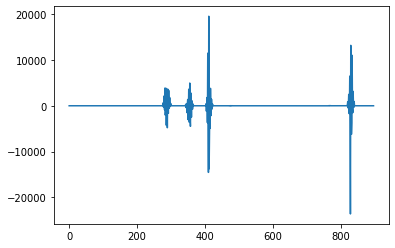

In [119]:
plt.plot(range(len(contactProblem.contactForces().flatten())),contactProblem.contactForces().flatten())

plt.show()

In [124]:
def getSpringForce(R, R_next, L_target=4.0, k=4.0):
    d = R_next - R
    F = k*d 
    return F
def getMaxDist(points):
    diffs = points[1:] - points[:-1] 
    dists = np.linalg.norm(diffs, axis=1)   
    return np.max(dists)
def moveTo(p, target):
    k = 2
    F = k*(target - p)
    return np.array(F)


In [ ]:
print(f"initial Max dist: {getMaxDist(combined)}")
for it in range(100000):
        DoFs = contactProblem.getDoFs().copy()
        points = DoFs[:nPoints*3].reshape((-1, 3))
        grad = contactProblem.contactForces()
        contactForce = grad[:nPoints*3].reshape((-1, 3))
        for i in range(0, n):
            
        
            if i in range(B_ind[0], B_ind[1]):
                continue
            else: 
                if i == nPoints-1:
                    springForce = getSpringForce(points[i], points[0]) + getSpringForce(points[i], points[i-1])
                else:
                    springForce = getSpringForce(points[i], points[i+1])+ getSpringForce(points[i], points[i-1])
                
            F = 0.001*springForce +0.1*contactForce[i]#+ 0.00001* moveTo(points[i], points[B_ind[0]])     
            F = F/ np.linalg.norm(F)
            points[i] = (points[i] +0.01*F)
    
        DoFs[:n_Points*3]=points.flatten()
        contactProblem.setDoFs(DoFs.flatten())    
        view.update()
        
        if it % 100 == 0 :
            print(f"{n*1000 + it} Max dist: {getMaxDist(points)}")

    
    

initial Max dist: 34.79627640413353
299000 Max dist: 46.19001235347636
299100 Max dist: 46.091978145824775
299200 Max dist: 46.01246624871658
299300 Max dist: 45.957602791845815
299400 Max dist: 45.885952182654826
299500 Max dist: 45.804806331040865
299600 Max dist: 45.73142973914324
299700 Max dist: 45.69483371903286
299800 Max dist: 45.626721815214765
299900 Max dist: 45.53956313323139
300000 Max dist: 45.4170837138522
300100 Max dist: 45.344513197390896
300200 Max dist: 45.263256416552174
300300 Max dist: 45.21663754398742
300400 Max dist: 45.141869976163385
300500 Max dist: 45.090186189559375
300600 Max dist: 45.03220906066716
300700 Max dist: 44.93276293814996
300800 Max dist: 44.90533963175665
300900 Max dist: 44.85308067959621
301000 Max dist: 44.81807514462745
301100 Max dist: 44.763291044913124
301200 Max dist: 44.70779490286094
301300 Max dist: 44.65814994579253
301400 Max dist: 44.53649085500379
301500 Max dist: 44.41523418951065
301600 Max dist: 44.2741640377834
301700 Max 

In [ ]:
view.update()